In [1]:
%run '00_rh_settings.ipynb'

Populating the interactive namespace from numpy and matplotlib


# Generate data

For importing data type: `make data`. Important! `input_filepath` and `output_filepath` parameters for make are ignored.

Stocks' data getting from Google and Yahoo fails, Robinhood limitation is 1 year. Fetch from Quandl.
Cache included for speedup and didn't overload Quandl network (hope historical data will not change :).

# Build features

1. Calculate daily return by closing price tag (dividends included only in Adjusted closing tag) with Pandas lag.

 Formula: $r_i = (P_{i+1} - P_{i}) / P_{i}$
2. Fix date


In [2]:
data_full = data.dropna()
data_full = data_full.query('SplitRatio == 1')
data_full["Date"] = data_full.index
data_full_pivot = data_full.pivot_table(index='Date', columns='Stock', values='Close')[["AAPL","FB","GOOG"]].dropna()

/usr/local/lib/python3.6/site-packages/pandas/core/reshape/pivot.py:81: FutureWarning: 'Date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  grouped = data.groupby(keys)


In [3]:
pd.concat([data_full_pivot.head(1), data_full_pivot.tail(1)])

Stock,AAPL,FB,GOOG
Date,,,
2014-03-28,536.86,60.01,559.99
2017-12-29,169.23,176.46,1046.40


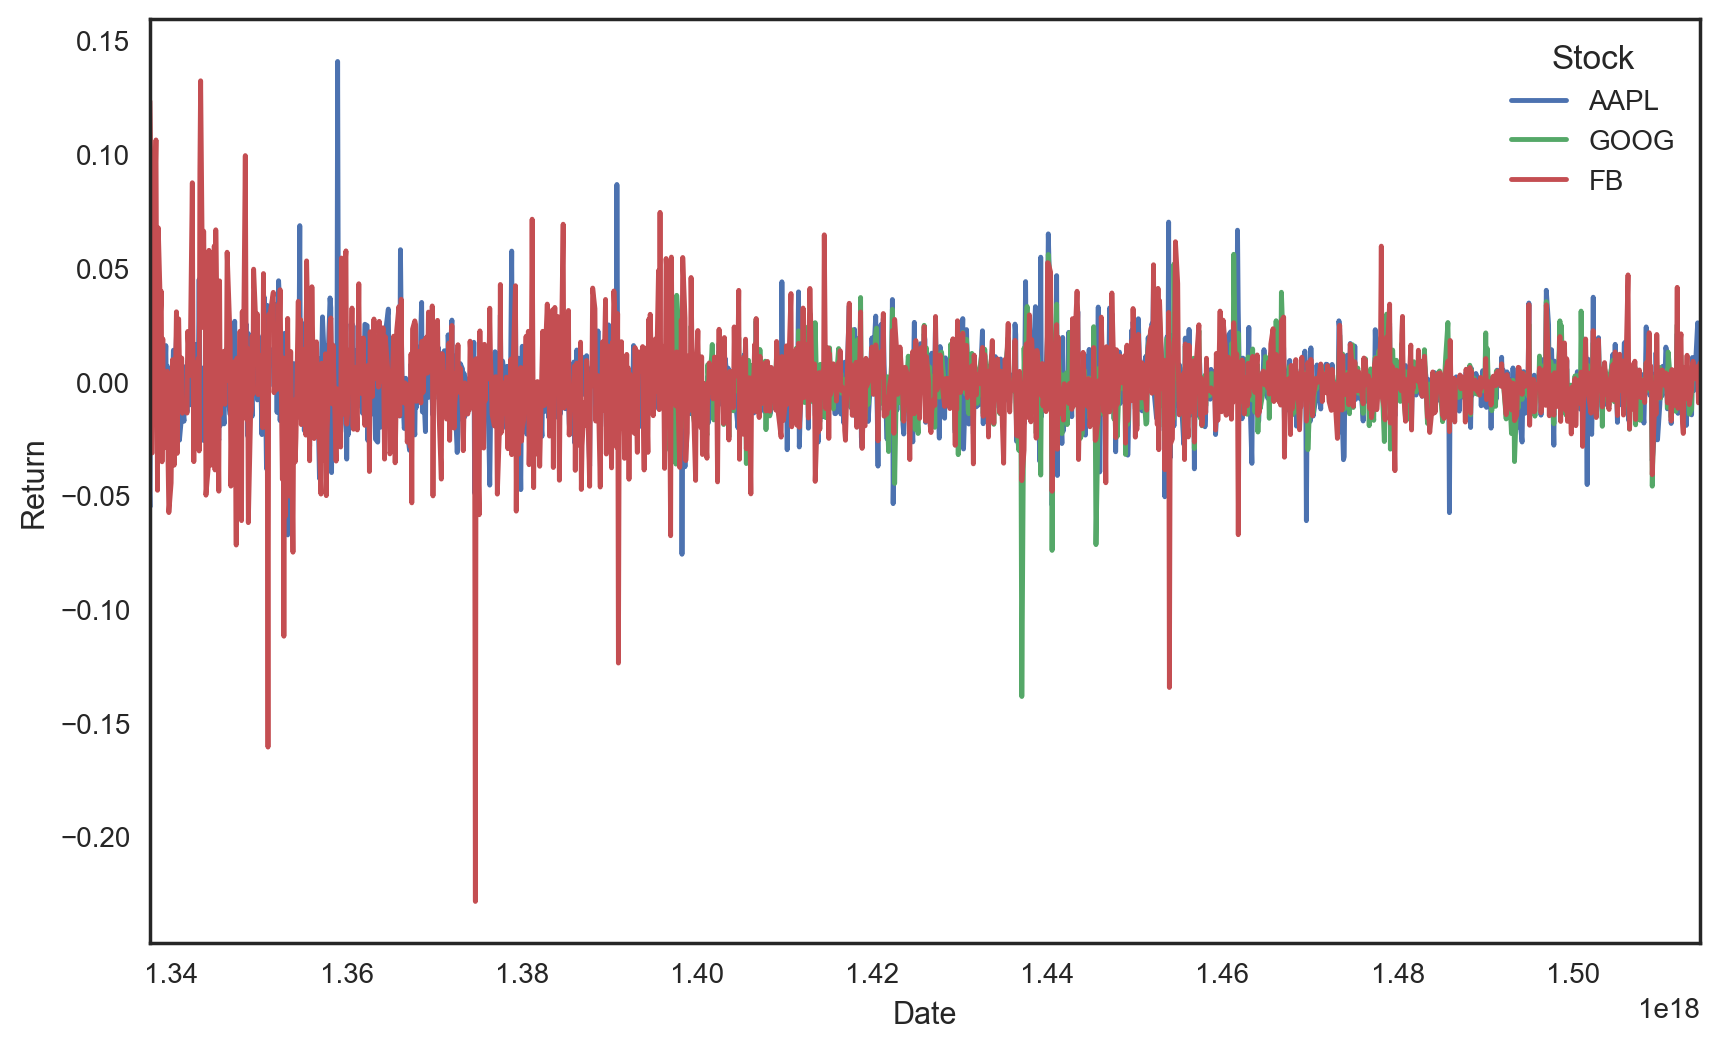

In [4]:
seaborn.tsplot(data_full, time="Date", unit = "Stock", 
               condition='Stock', value='Return')

In [5]:
from statsmodels.nonparametric.smoothers_lowess import lowess
data_full["Return_smooth"] = np.NaN
for stock in data_full.Stock.unique():
        # One independent smoothing per Sensor/Measure condition.
        df_filt = data_full.loc[(data_full.Stock == stock)]
        # Frac is equivalent to span in R
        filtered = lowess(df_filt.Return, df_filt.Date, frac=0.09, return_sorted=False) 
        data_full.loc[data_full.Stock == stock,"Return_smooth"] = filtered

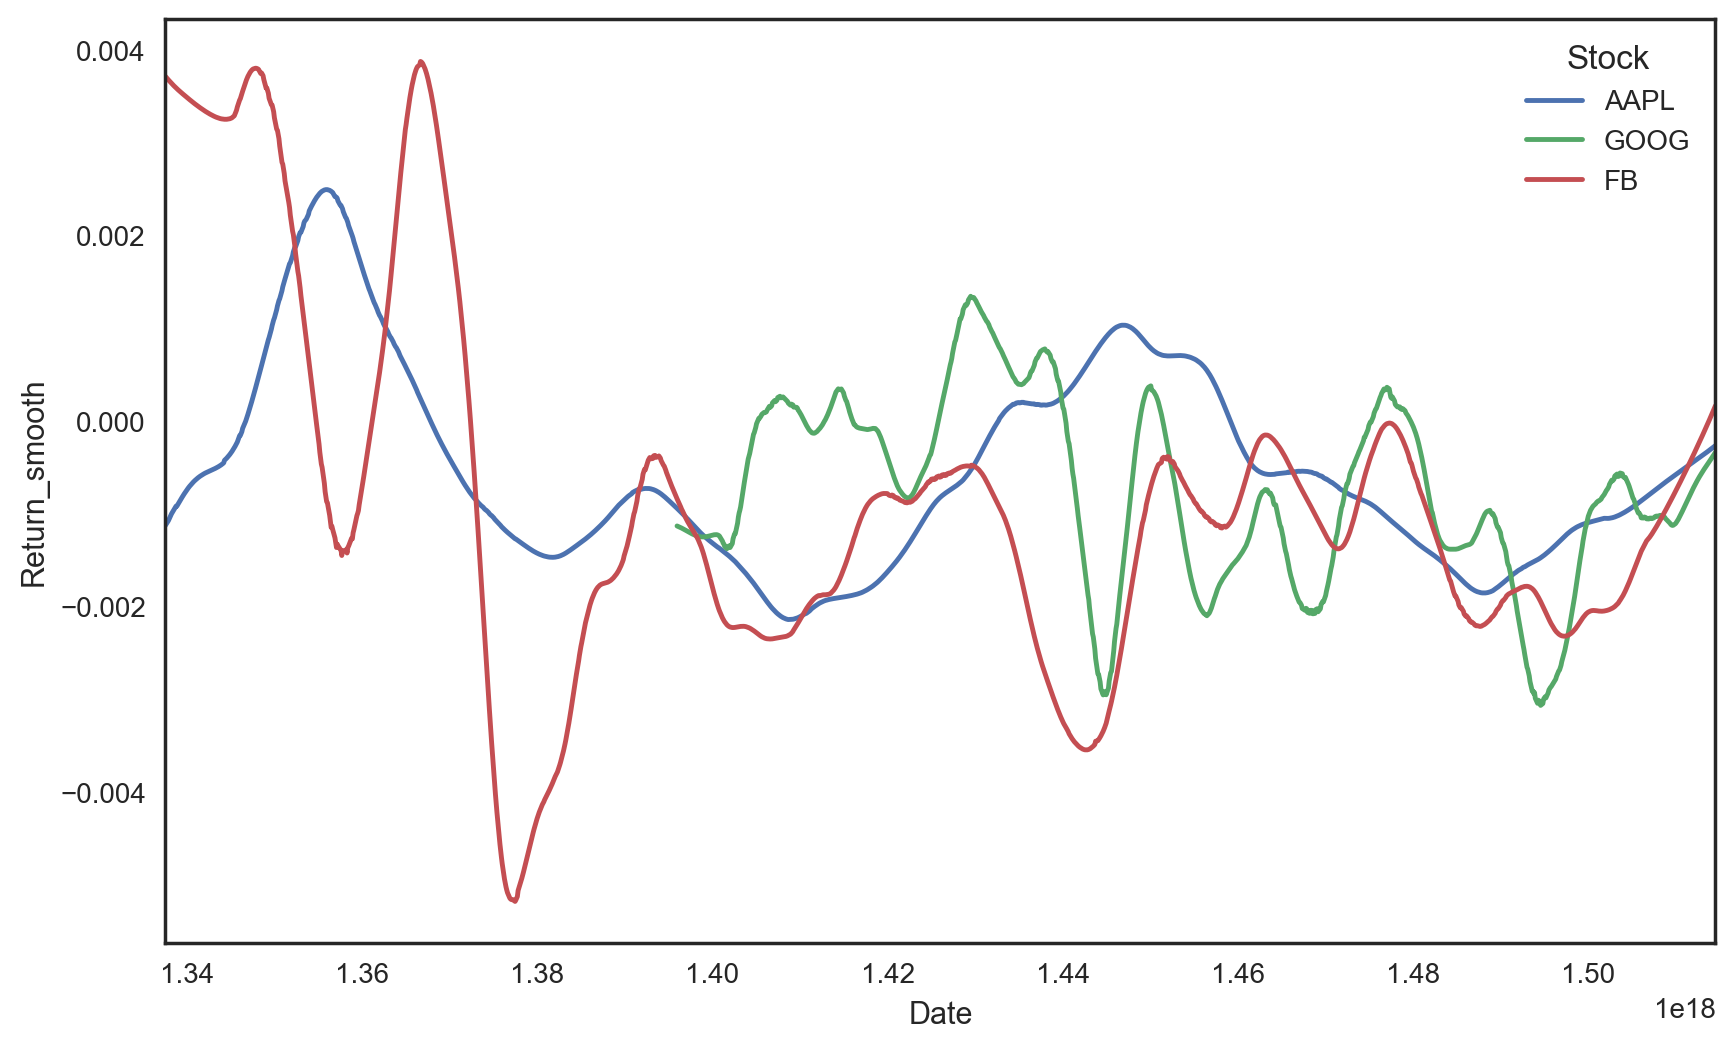

In [6]:
seaborn.tsplot(data_full, time="Date", unit = "Stock", 
               condition='Stock', value='Return_smooth')

In [7]:
data_full_pivot.cumsum(axis=1).sum()

Stock
AAPL    136995.3469
FB      241327.6250
GOOG    916295.4679
dtype: float64

In [8]:
data_full.groupby(['Stock'])['Return_raw'].sum()

Stock
AAPL   -630.3500
FB     -138.2282
GOOG   -487.9400
Name: Return_raw, dtype: float64

In [9]:
data_full["Return"].describe()

count    4620.000000
mean       -0.000852
std         0.018185
min        -0.228441
25%        -0.009972
50%        -0.000872
75%         0.007275
max         0.140966
Name: Return, dtype: float64

No data on 01.01.2009, it seems stock exchange was closed.

In [10]:
data.query("index == 20090101")

,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume,Stock,Return,Return_raw,AdjReturn
Date,,,,,,,,,,,,,,,,


Before 2015 we haven't full Google and Facebook tags

Dates of their first appear:

In [11]:
data.loc[data.Stock == "GOOG"].head(1).index
data.loc[data.Stock == "FB"].head(1).index

DatetimeIndex(['2014-03-27'], dtype='datetime64[ns]', name='Date', freq=None)

DatetimeIndex(['2012-05-18'], dtype='datetime64[ns]', name='Date', freq=None)

In [12]:
data.query("Stock == 'AAPL'")["AdjReturn"].describe()

count    2262.000000
mean       -0.001044
std         0.016603
min        -0.081508
25%        -0.010209
50%        -0.000992
75%         0.006974
max         0.140966
Name: AdjReturn, dtype: float64

In-day trading ends with small negative results

In [13]:
data.groupby("Stock")["AdjReturn"].describe()

,count,mean,std,min,25%,50%,75%,max
Stock,,,,,,,,
AAPL,2262.0,-0.001044,0.016603,-0.081508,-0.010209,-0.000992,0.006974,0.140966
FB,1412.0,-0.000821,0.022686,-0.228441,-0.011723,-0.000936,0.009116,0.132462
GOOG,947.0,-0.000568,0.013683,-0.138320,-0.007674,-0.000475,0.005804,0.056165


## Time-series that we well use - Apple stock (AAPL)

In [14]:
ts_series=data.query("Stock == 'AAPL'")["Return"].dropna()
#ts_series=data.query("Stock == 'AAPL'").Close.dropna()
ts_series.head()

Date
2009-01-05   -0.040495
2009-01-06    0.016771
2009-01-07    0.022085
2009-01-08   -0.018231
2009-01-09    0.023405
Name: Return, dtype: float64

## Return (raw values) for Apple stocks

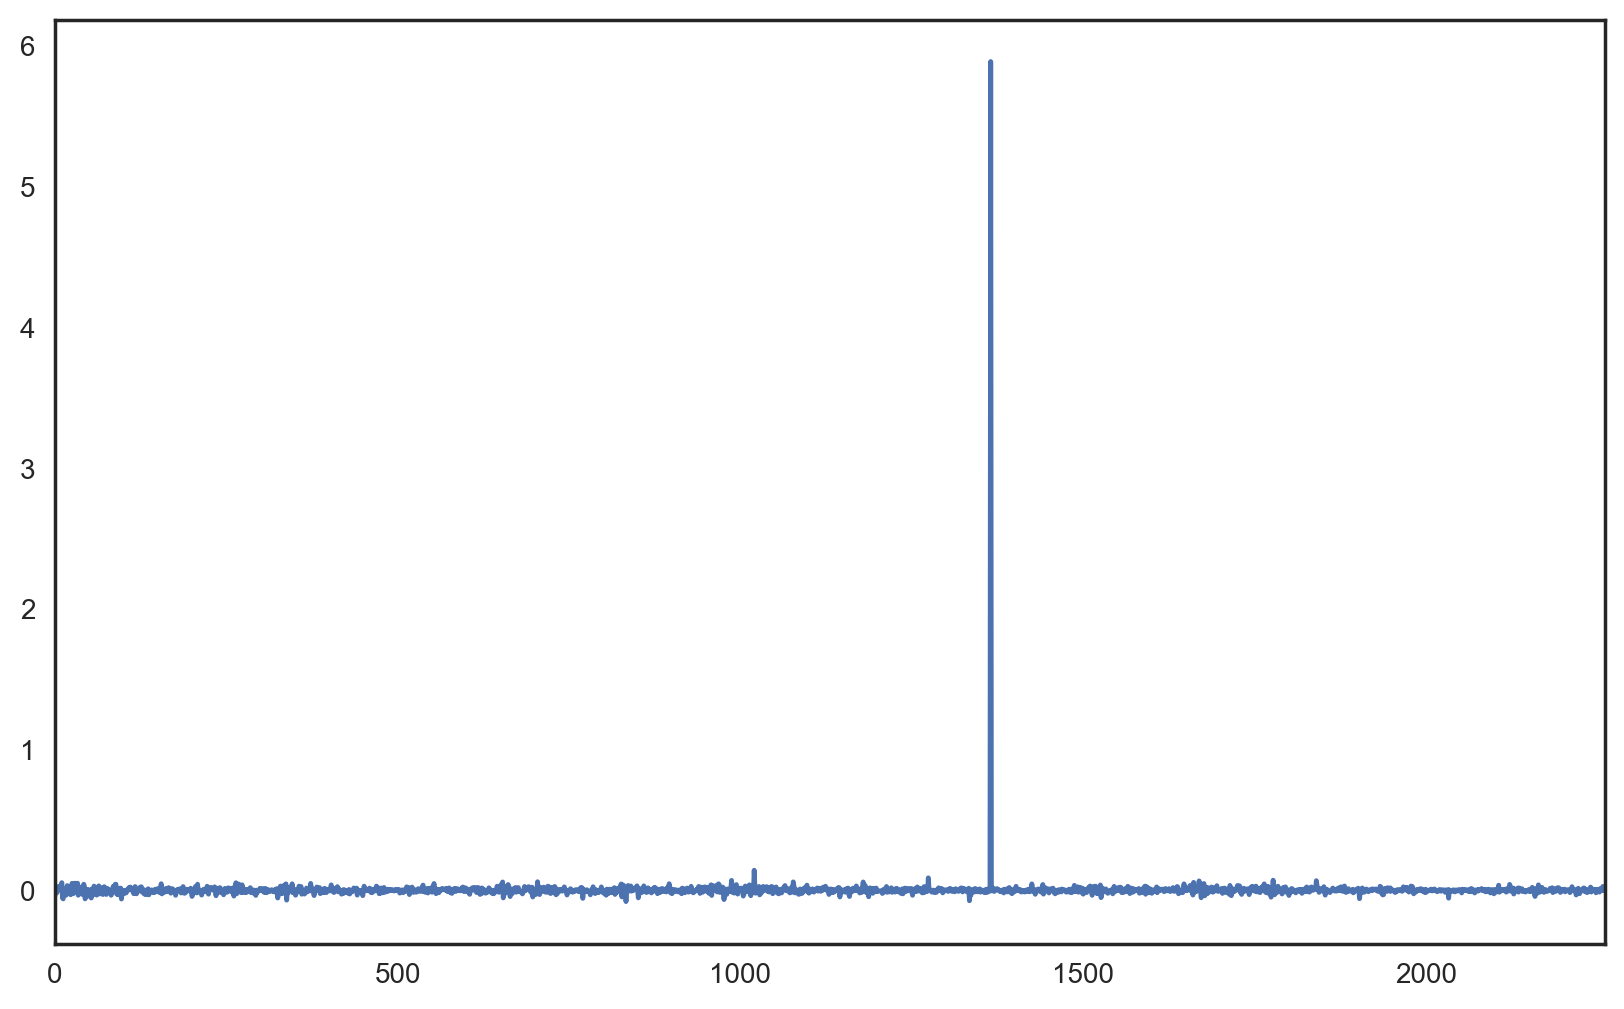

In [15]:
import matplotlib.dates as mdates

AAPL = data.query("Stock == 'AAPL'").dropna()

seaborn.tsplot(AAPL["Return"])


## Outlier detection

In [16]:
data.query("Return > 3").index

DatetimeIndex(['2014-06-09'], dtype='datetime64[ns]', name='Date', freq=None)

Split of Apple stock 1 to 7 (06.09.2014): https://vc.ru/4064-apple-stock

In [17]:
data.query("index >= 20140605 & index < 20140612 & Stock == 'AAPL'")

,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume,Stock,Return,Return_raw,AdjReturn
Date,,,,,,,,,,,,,,,,
2014-06-05,646.20,649.3699,642.61,647.35,10850200.0,0.0,1.0,86.889156,87.315386,86.406439,87.043787,75951400.0,AAPL,-0.003908,-2.53,-0.003908
2014-06-06,649.90,651.2600,644.47,645.57,12497800.0,0.0,1.0,87.386665,87.569533,86.656538,86.804445,87484600.0,AAPL,0.002757,1.78,0.002757
2014-06-09,92.70,93.8800,91.75,93.70,75414997.0,0.0,7.0,87.252203,88.362857,86.358033,88.193435,75414997.0,AAPL,5.889755,551.87,-0.015749
2014-06-10,94.73,95.0500,93.57,94.25,62777000.0,0.0,1.0,89.162904,89.464098,88.071075,88.711112,62777000.0,AAPL,-0.005836,-0.55,-0.005836
2014-06-11,94.13,94.7600,93.47,93.86,45681000.0,0.0,1.0,88.598165,89.191141,87.976952,88.344032,45681000.0,AAPL,0.004155,0.39,0.004155


## Factor analysis (PCA, FCA)

Similar task was in "Introduce to Machine Learning" Coursera course, most close to S&P500 main component price tag was Visa company.